In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_absolute_error
from prophet import Prophet
from google.colab import files
import pandas as pd
uploaded = files.upload()


Saving monthly-beer-production-in-austr.csv to monthly-beer-production-in-austr.csv


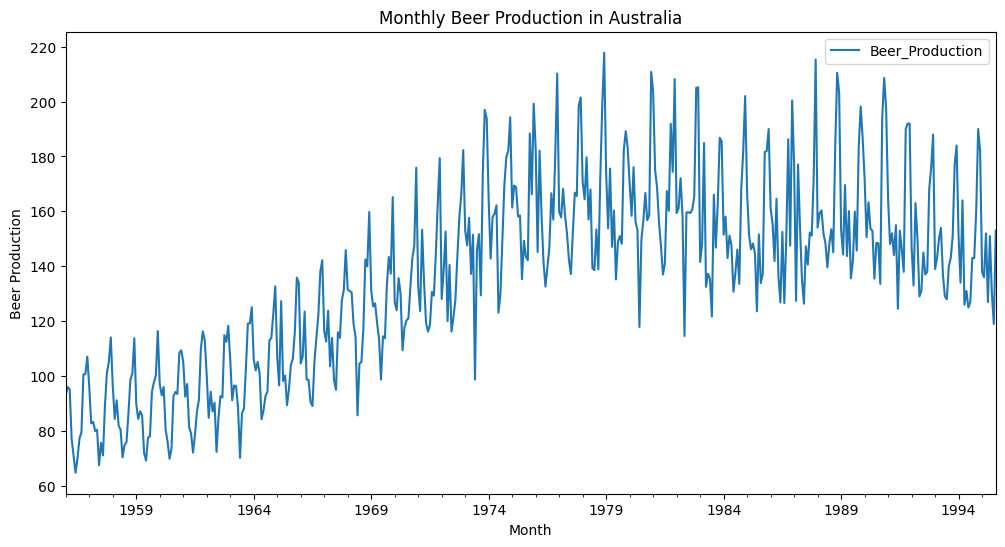

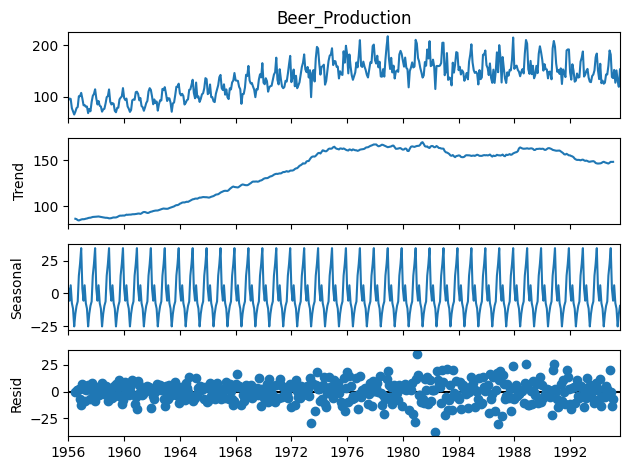

Trend, Seasonality, and Residual components extracted. Check the plots.


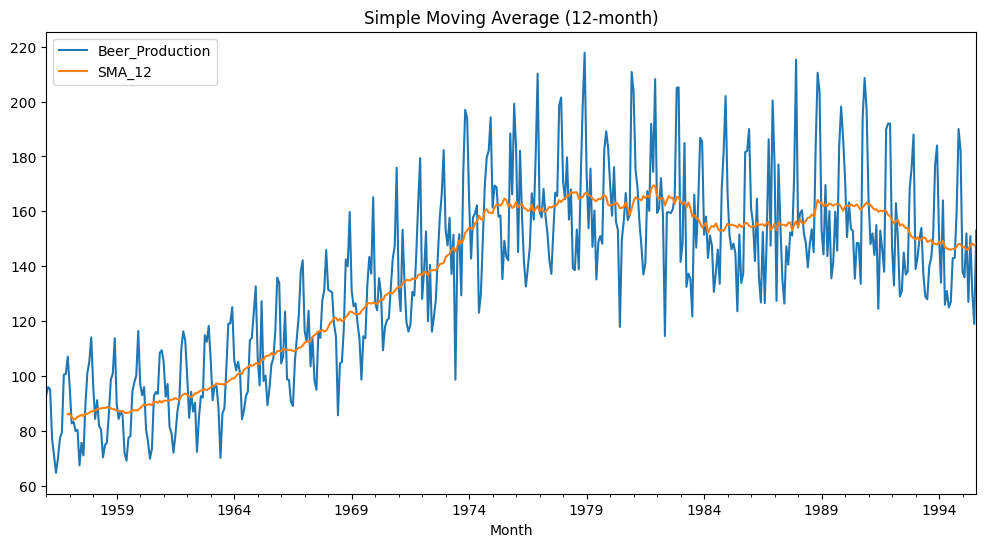

<ipython-input-15-351c1d203c32>:35: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['WMA_12'][-len(wma_values):] = wma_values


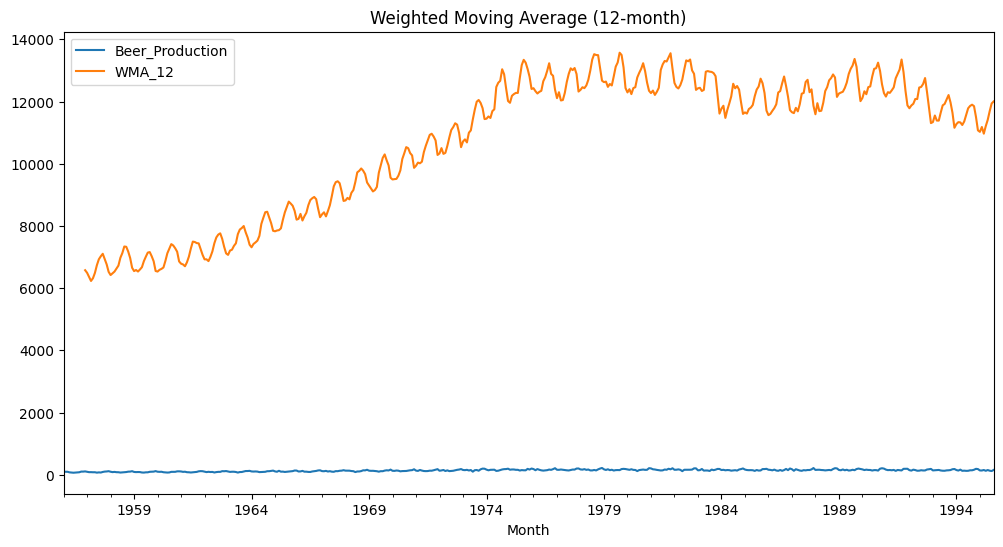

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


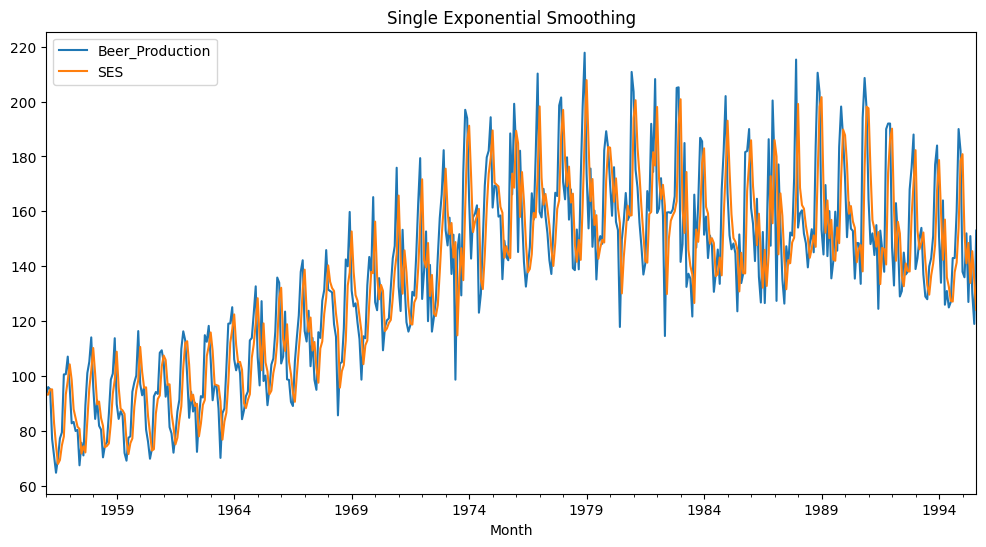

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


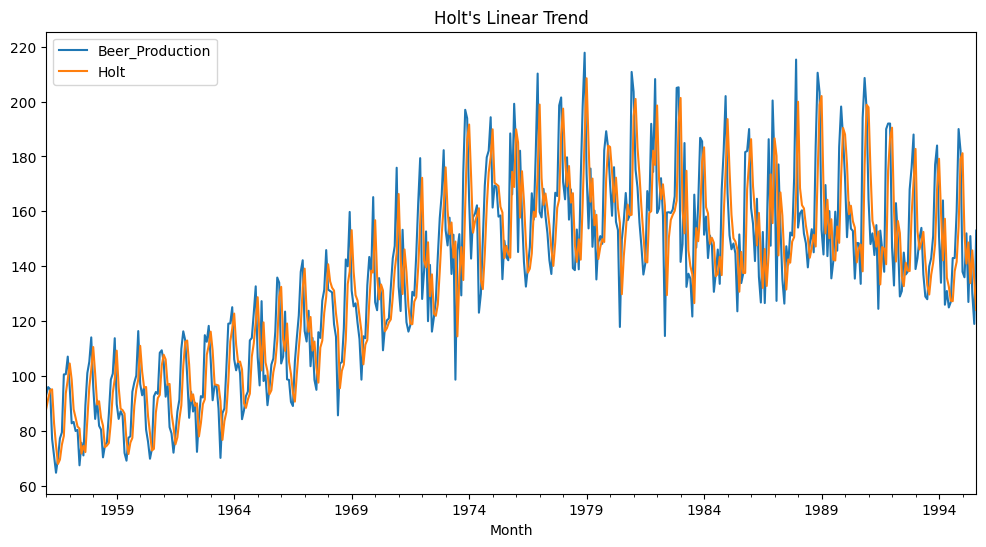

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


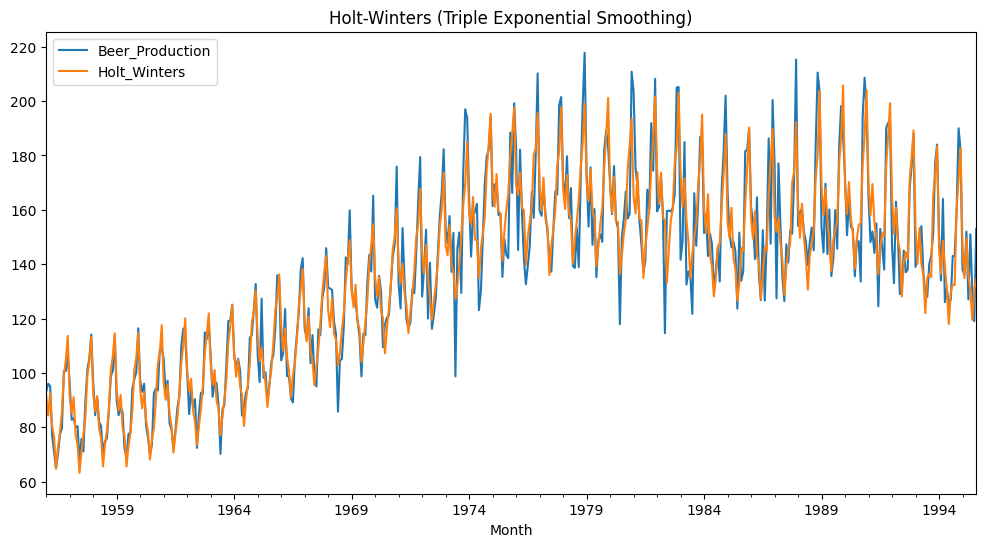

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjiw9_h_2/7922aw3a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjiw9_h_2/951wlm9v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26716', 'data', 'file=/tmp/tmpjiw9_h_2/7922aw3a.json', 'init=/tmp/tmpjiw9_h_2/951wlm9v.json', 'output', 'file=/tmp/tmpjiw9_h_2/prophet_model4os2_zty/prophet_model-20241224210036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:00:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:00:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/

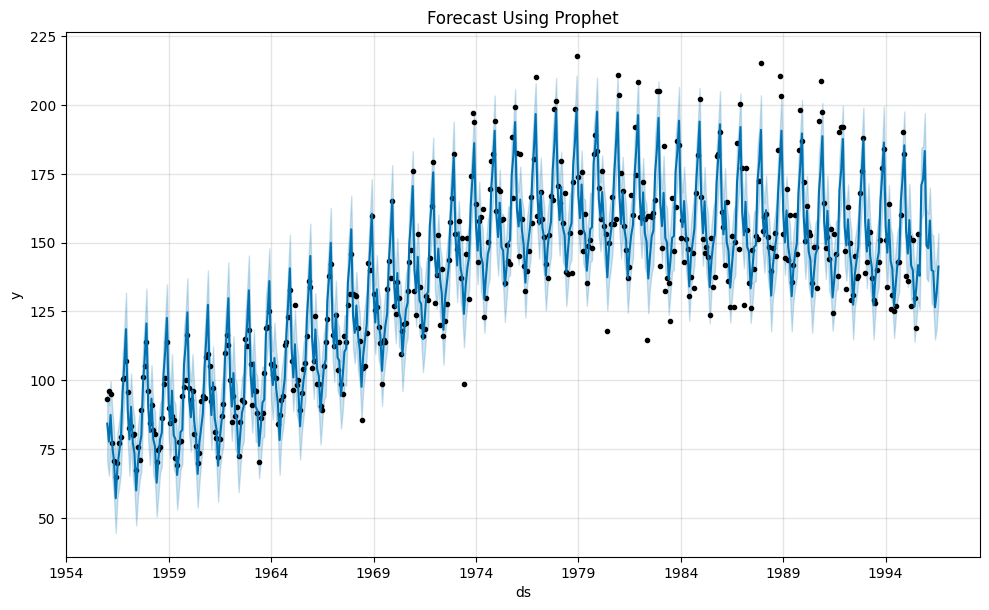

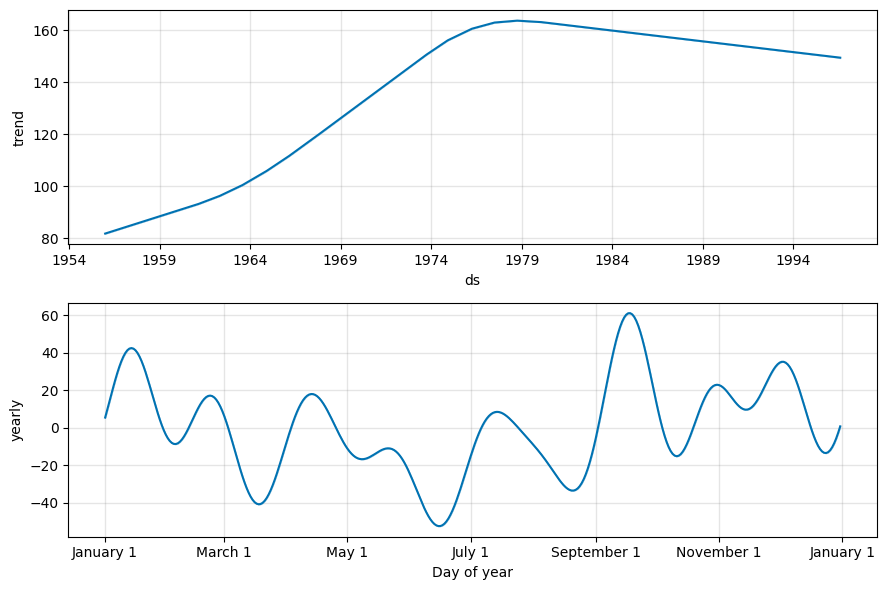

Model Evaluation Metrics:
Holt-Winters MAE: 7.40, RMSE: 9.90
SES MAE: 14.93, RMSE: 18.89
Holt MAE: 14.93, RMSE: 18.89
Prophet MAE: 9.62, RMSE: 10.59


In [15]:

import math
# 1. Data Loading and Exploration
file_path = 'monthly-beer-production-in-austr.csv'
data = pd.read_csv(file_path, index_col=0, parse_dates=True)
data.columns = ['Beer_Production']
data = data.dropna()

# Plot the original time series
data.plot(figsize=(12, 6), title='Monthly Beer Production in Australia', ylabel='Beer Production')
plt.show()

# 2. Time Series Decomposition
result = seasonal_decompose(data['Beer_Production'], model='additive', period=12)

# Plot each component
result.plot()
plt.show()

# Observations
print("Trend, Seasonality, and Residual components extracted. Check the plots.")

# 3. Trend Estimation Techniques
# Simple Moving Average (SMA)
data['SMA_12'] = data['Beer_Production'].rolling(window=12).mean()
data[['Beer_Production', 'SMA_12']].plot(figsize=(12, 6), title='Simple Moving Average (12-month)')
plt.show()

# Weighted Moving Average (WMA)
def weighted_moving_average(series, weights):
    return np.convolve(series, weights, mode='valid')

weights = np.arange(1, 13)
data['WMA_12'] = np.nan
wma_values = weighted_moving_average(data['Beer_Production'], weights)
data['WMA_12'][-len(wma_values):] = wma_values
data[['Beer_Production', 'WMA_12']].plot(figsize=(12, 6), title='Weighted Moving Average (12-month)')
plt.show()

# 4. Exponential Smoothing
# Single Exponential Smoothing (SES)
ses_model = ExponentialSmoothing(data['Beer_Production'], trend=None, seasonal=None).fit()
data['SES'] = ses_model.fittedvalues
data[['Beer_Production', 'SES']].plot(figsize=(12, 6), title='Single Exponential Smoothing')
plt.show()

# Double Exponential Smoothing (Holt's Linear Trend)
holt_model = ExponentialSmoothing(data['Beer_Production'], trend='add', seasonal=None).fit()
data['Holt'] = holt_model.fittedvalues
data[['Beer_Production', 'Holt']].plot(figsize=(12, 6), title="Holt's Linear Trend")
plt.show()

# Triple Exponential Smoothing (Holt-Winters)
hw_model = ExponentialSmoothing(data['Beer_Production'], trend='add', seasonal='add', seasonal_periods=12).fit()
data['Holt_Winters'] = hw_model.fittedvalues
data[['Beer_Production', 'Holt_Winters']].plot(figsize=(12, 6), title='Holt-Winters (Triple Exponential Smoothing)')
plt.show()

# 5. Forecasting Using Prophet
prophet_data = data.reset_index().rename(columns={'Month': 'ds', 'Beer_Production': 'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_data)

future = prophet_model.make_future_dataframe(periods=12, freq='M')
forecast = prophet_model.predict(future)

# Plot forecast
prophet_model.plot(forecast)
plt.title('Forecast Using Prophet')
plt.show()

# Trend and seasonality components
prophet_model.plot_components(forecast)
plt.show()

# 6. Evaluation and Interpretation
# Compute metrics
actual = data['Beer_Production']
predictions_hw = data['Holt_Winters'].dropna()
predictions_ses = data['SES'].dropna()
predictions_holt = data['Holt'].dropna()

mae_hw = mean_absolute_error(actual[-len(predictions_hw):], predictions_hw)
rmse_hw = math.sqrt(mean_squared_error(actual[-len(predictions_hw):], predictions_hw))

mae_ses = mean_absolute_error(actual[-len(predictions_ses):], predictions_ses)
rmse_ses = math.sqrt(mean_squared_error(actual[-len(predictions_ses):], predictions_ses))

mae_holt = mean_absolute_error(actual[-len(predictions_holt):], predictions_holt)
rmse_holt = math.sqrt(mean_squared_error(actual[-len(predictions_holt):], predictions_holt))

# Prophet Metrics
actual_future = actual[-12:]
predicted_future = forecast['yhat'][-12:]
mae_prophet = mean_absolute_error(actual_future, predicted_future)
rmse_prophet = math.sqrt(mean_squared_error(actual_future, predicted_future))

# Display metrics
print("Model Evaluation Metrics:")
print(f"Holt-Winters MAE: {mae_hw:.2f}, RMSE: {rmse_hw:.2f}")
print(f"SES MAE: {mae_ses:.2f}, RMSE: {rmse_ses:.2f}")
print(f"Holt MAE: {mae_holt:.2f}, RMSE: {rmse_holt:.2f}")
print(f"Prophet MAE: {mae_prophet:.2f}, RMSE: {rmse_prophet:.2f}")


1. Time Series Decomposition
Purpose: Break down the time series into components: trend, seasonality, and residuals.
Steps:
seasonal_decompose with an additive model is applied (because the data likely exhibits additive seasonality).
Each component is plotted separately to analyze the underlying patterns.
2. Trend Estimation Techniques
a. Simple Moving Average (SMA)
A rolling average is calculated over a 12-month window to smooth the time series and reveal the trend component.
The SMA is plotted alongside the original data to compare.
b. Weighted Moving Average (WMA)
Instead of equal weights, increasing weights (1, 2, ..., 12) are applied to more recent observations.
This gives more importance to recent data points in the trend calculation.
The WMA is plotted alongside the original data.
3. Exponential Smoothing
a. Single Exponential Smoothing (SES)
Purpose: Model data without a clear trend or seasonality.
Steps:
SES is applied, and the fitted values are plotted alongside the original data.
b. Double Exponential Smoothing (Holt’s Linear Trend)
Purpose: Model data with a trend but no seasonality.
Steps:
Holt’s method adds a trend component to SES, and the results are plotted.
c. Triple Exponential Smoothing (Holt-Winters)
Purpose: Model data with both trend and seasonality.
Steps:
Holt-Winters smoothing accounts for both components (additive model), and the results are plotted.
4. Forecasting Using Prophet
Purpose: Use Facebook's Prophet library for time series forecasting.
Steps:
The data is reformatted to fit Prophet’s input structure (ds for date and y for values).
A Prophet model is fit, and forecasts are generated for the next 12 months.
The forecast and its components (trend, seasonality, uncertainty) are plotted.
6. Evaluation and Interpretation
a. Metrics Calculation
Purpose: Evaluate the accuracy of the models using metrics.
Steps:
MAE (Mean Absolute Error): Measures the average magnitude of errors.
RMSE (Root Mean Squared Error): Penalizes large errors more heavily than MAE.
Models evaluated:
Holt-Winters
Single Exponential Smoothing
Holt’s Linear Trend
Prophet
b. Alignment of Predictions
To avoid index mismatches, only overlapping periods between actual and predicted values are considered.
c. Metrics Display
Results for each model (Holt-Winters, SES, Holt, Prophet) are displayed in terms of MAE and RMSE.
 Key Insights
Decomposition: Provides insights into the trend, seasonality, and irregularity of the data.
Smoothing Techniques: Highlight the trend and provide alternatives to model the data based on its nature (e.g., trend-only, seasonality).
Prophet Model: Handles complex seasonality and trends effectively, suitable for forecasting.
Evaluation: Quantifies model performance, helping to identify the most accurate forecasting method